In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',200)

# Data Exploration & Feature Engineering

In this notebook, I will explore the raw data download from [kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data) about Lending Club's issued loans from April 2008 to September 2018. The original dataset consists 2,260,668 loans with 145 pieces of information about the loan.

At the end of this process, the training data consists 1,045,085 loans with 58 pieces of information.

**The Goals for this exploration include:**


1.   Understand how the data was documented
2.   Identify potential problems of the data
3.   Transform the data in the way that machine learning model understands

In [0]:
loan=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Lending Club Project_Joint/loan_original.csv',low_memory=False)

In [5]:
# As shown, the original data includes 2,260,668 loans with 145 columns
loan.shape

(2260668, 145)

In [23]:
# The loans were issued from Apr. 2008 to Sep. 2018
print(' Earliest Issue Date: ',min(loan.issue_d),'\n','Latest Issue Date: ', max(loan.issue_d))

 Earliest Issue Date:  Apr-2008 
 Latest Issue Date:  Sep-2018


In [6]:
# First five rows of the data
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,...,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,...,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0.0,Apr-2011,0.0,NaN,NaN,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,...,0.0,0.0,136927.0,11749.0,13800.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,MORTGAGE,92000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,985xx,WA,16.74,0.0,Feb-2006,0.0,NaN,NaN,10.0,0.0,5468,78.1,13.0,w,3831.93,3831.93,286.71,286.71,...,0.0,0.0,385183.0,36151.0,5000.0,44984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,MORTGAGE,57250.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,212xx,MD,26.35,0.0,Dec-2000,0.0,NaN,NaN,12.0,0.0,829,3.6,26.0,w,29339.02,29339.02,1423.21,1423.21,...,0.0,0.0,157548.0,29674.0,9300.0,32332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## 1. IDs and Member_ID
The id and member_id columns have no values; thus:
- **member_id** column will be dropped
- **id** column will be set as the data index 

In [7]:
print(loan.id.describe(),loan.member_id.describe())

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id, dtype: float64 count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: member_id, dtype: float64


In [0]:
loan['id']=loan.index
loan=loan.drop(columns=['member_id'])

## 2. Loan Status

The data includes multiple loan statuses, and the break-downs are: 
- Fully Paid: 46.09% 
- Current: 40.68%
- Charged Off: 11.57%
- Late (31-120 days): 0.97%
- In Grace Period: 0.40%
- Late (16-30 days): 0.17%
- Does not meet the credit policy. Status:Fully Paid: 0.09%
- Does not meet the credit policy. Status:Charged Off: 0.03%
- Default: 0.0014%

The ultimate statuses of the loan can either be fully paid or charged off, and other loan status are in-progress loan and will be transfer to either status at the end of the term.

As in-progress loans were unclear on ultimate status; thus for model building purposes, in-progress loans would be excluded moving forward.

Following steps took on loan statuses
- **Exclude loan status**: Current, In Grace Period, Late (16-30 days), Default, Current

- **Mark as Fully Paid**: Fully Paid, Does not meet the credit policy. Status: Fully Paid

- **Mark as Charged Off**: Charged Off, Does not meet the credit policy. Status: Charged Off

In [31]:
loan.loan_status.value_counts()/len(loan)

Fully Paid                                             0.460904
Current                                                0.406824
Charged Off                                            0.115742
Late (31-120 days)                                     0.009686
In Grace Period                                        0.003960
Late (16-30 days)                                      0.001653
Does not meet the credit policy. Status:Fully Paid     0.000879
Does not meet the credit policy. Status:Charged Off    0.000337
Default                                                0.000014
Name: loan_status, dtype: float64

In [0]:
# In 'finished' column, 1 represents finished and 0 represents in-progress loans
loan['finished']=np.where(loan.loan_status.isin(['Fully Paid','Charged Off','Does not meet the credit policy. Status:Fully Paid','Does not meet the credit policy. Status:Charged Off']),1,0)

In [10]:
# Finished vs. In-progress loans break down
loan.finished.value_counts()

1    1306356
0     954312
Name: finished, dtype: int64

In [0]:
loan_finished=loan[loan.finished==1]

In [13]:
loan_finished.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,finished
100,100,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,Supervisor,5 years,MORTGAGE,100000.0,Source Verified,Dec-2018,Fully Paid,n,NaN,NaN,debt_consolidation,Debt consolidation,917xx,CA,30.46,0.0,Jan-2012,0.0,51.0,84.0,11.0,1.0,15603,37.0,19.0,w,0.0,0.0,30026.442500,30026.44,30000.0,...,0.0,527120.0,98453.0,28600.0,101984.0,52417.0,Jul-2006,0.0,1.0,16.0,25.2,2.0,15.0,0.0,0.0,70.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
152,152,40000,40000,40000.0,60 months,16.14,975.71,C,C4,Assistant to the Treasurer (Payroll),< 1 year,MORTGAGE,45000.0,Verified,Dec-2018,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,456xx,OH,50.53,0.0,Jun-2009,0.0,NaN,NaN,18.0,0.0,34971,64.5,37.0,w,0.0,0.0,40856.678960,40856.68,40000.0,...,0.0,344802.0,161720.0,45700.0,167965.0,47188.0,Apr-1990,0.0,1.0,32.0,61.1,16.0,19.0,0.0,0.0,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
170,170,20000,20000,20000.0,36 months,7.56,622.68,A,A3,Teacher,10+ years,MORTGAGE,100000.0,Not Verified,Dec-2018,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,982xx,WA,18.92,0.0,Feb-1999,0.0,48.0,NaN,9.0,0.0,25416,29.9,19.0,w,0.0,0.0,20215.792430,20215.79,20000.0,...,0.0,622183.0,71569.0,85100.0,74833.0,43287.0,Aug-1998,0.0,3.0,10.0,29.7,2.0,7.0,0.0,0.0,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
186,186,4500,4500,4500.0,36 months,11.31,147.99,B,B3,Accounts Examiner III,10+ years,RENT,38500.0,Not Verified,Dec-2018,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,786xx,TX,4.64,0.0,Dec-2003,0.0,25.0,NaN,12.0,0.0,4472,15.3,25.0,w,0.0,0.0,4549.217149,4549.22,4500.0,...,0.0,53795.0,29137.0,15100.0,24595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
215,215,8425,8425,8425.0,36 months,27.27,345.18,E,E5,Senior Director Risk Management,3 years,MORTGAGE,450000.0,Verified,Dec-2018,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,020xx,MA,12.37,0.0,Oct-1997,0.0,NaN,NaN,21.0,0.0,36812,65.7,37.0,w,0.0,0.0,8735.148975,8735.15,8425.0,...,0.0,768304.0,189194.0,45800.0,189054.0,141905.0,Jun-2013,0.0,1.0,4.0,77.4,1.0,4.0,0.0,0.0,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1


In [0]:
results=pd.DataFrame({'id':loan_finished.index,'results': np.where(loan_finished.loan_status.isin(['Fully Paid','Does not meet the credit policy. Status:Fully Paid']),'Fully Paid','Charged Off')})

In [0]:
loan_finished=loan_finished.merge(results,on='id')

In [16]:
loan_finished.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,finished,results
0,100,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,Supervisor,5 years,MORTGAGE,100000.0,Source Verified,Dec-2018,Fully Paid,n,NaN,NaN,debt_consolidation,Debt consolidation,917xx,CA,30.46,0.0,Jan-2012,0.0,51.0,84.0,11.0,1.0,15603,37.0,19.0,w,0.0,0.0,30026.442500,30026.44,30000.0,...,527120.0,98453.0,28600.0,101984.0,52417.0,Jul-2006,0.0,1.0,16.0,25.2,2.0,15.0,0.0,0.0,70.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1,Fully Paid
1,152,40000,40000,40000.0,60 months,16.14,975.71,C,C4,Assistant to the Treasurer (Payroll),< 1 year,MORTGAGE,45000.0,Verified,Dec-2018,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,456xx,OH,50.53,0.0,Jun-2009,0.0,NaN,NaN,18.0,0.0,34971,64.5,37.0,w,0.0,0.0,40856.678960,40856.68,40000.0,...,344802.0,161720.0,45700.0,167965.0,47188.0,Apr-1990,0.0,1.0,32.0,61.1,16.0,19.0,0.0,0.0,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1,Fully Paid
2,170,20000,20000,20000.0,36 months,7.56,622.68,A,A3,Teacher,10+ years,MORTGAGE,100000.0,Not Verified,Dec-2018,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,982xx,WA,18.92,0.0,Feb-1999,0.0,48.0,NaN,9.0,0.0,25416,29.9,19.0,w,0.0,0.0,20215.792430,20215.79,20000.0,...,622183.0,71569.0,85100.0,74833.0,43287.0,Aug-1998,0.0,3.0,10.0,29.7,2.0,7.0,0.0,0.0,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1,Fully Paid
3,186,4500,4500,4500.0,36 months,11.31,147.99,B,B3,Accounts Examiner III,10+ years,RENT,38500.0,Not Verified,Dec-2018,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,786xx,TX,4.64,0.0,Dec-2003,0.0,25.0,NaN,12.0,0.0,4472,15.3,25.0,w,0.0,0.0,4549.217149,4549.22,4500.0,...,53795.0,29137.0,15100.0,24595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1,Fully Paid
4,215,8425,8425,8425.0,36 months,27.27,345.18,E,E5,Senior Director Risk Management,3 years,MORTGAGE,450000.0,Verified,Dec-2018,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,020xx,MA,12.37,0.0,Oct-1997,0.0,NaN,NaN,21.0,0.0,36812,65.7,37.0,w,0.0,0.0,8735.148975,8735.15,8425.0,...,768304.0,189194.0,45800.0,189054.0,141905.0,Jun-2013,0.0,1.0,4.0,77.4,1.0,4.0,0.0,0.0,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1,Fully Paid


In [0]:
loan_finished=loan_finished.drop(columns=['finished','loan_status'])

In [0]:
# Optional: for saving RAM, to export a new version of selected finished loan
loan_finished.to_csv('/content/drive/My Drive/Colab Notebooks/Lending Club Project_Joint/loan_finished.csv',index=False)

## 3. Split Training and Testing Sets

In the modeling building process, 80% of finished loans would be used as training data, which will be used to build the model, and 20% of finished loans would be used as testing data, which will be used to test the model performance, and identify if the model is overfitted.

The testing data is treated as new loan applications come in. During the model building process, the testing data stays untouched as in reality, the testing data results stay unkown until the loan is finished.

The seperation is not based on issued dates, for two reasons:
1. The goal is to find time invarite variables that help predit the probability of charge off.

2. The finished loans were unevenly distributed to different years, so seperate based on issued dates may introduce bias into the model. For example, latest issued loans may have low charged off rate due to many finished loans in those years were early paid in full rather repaid as scheduled.


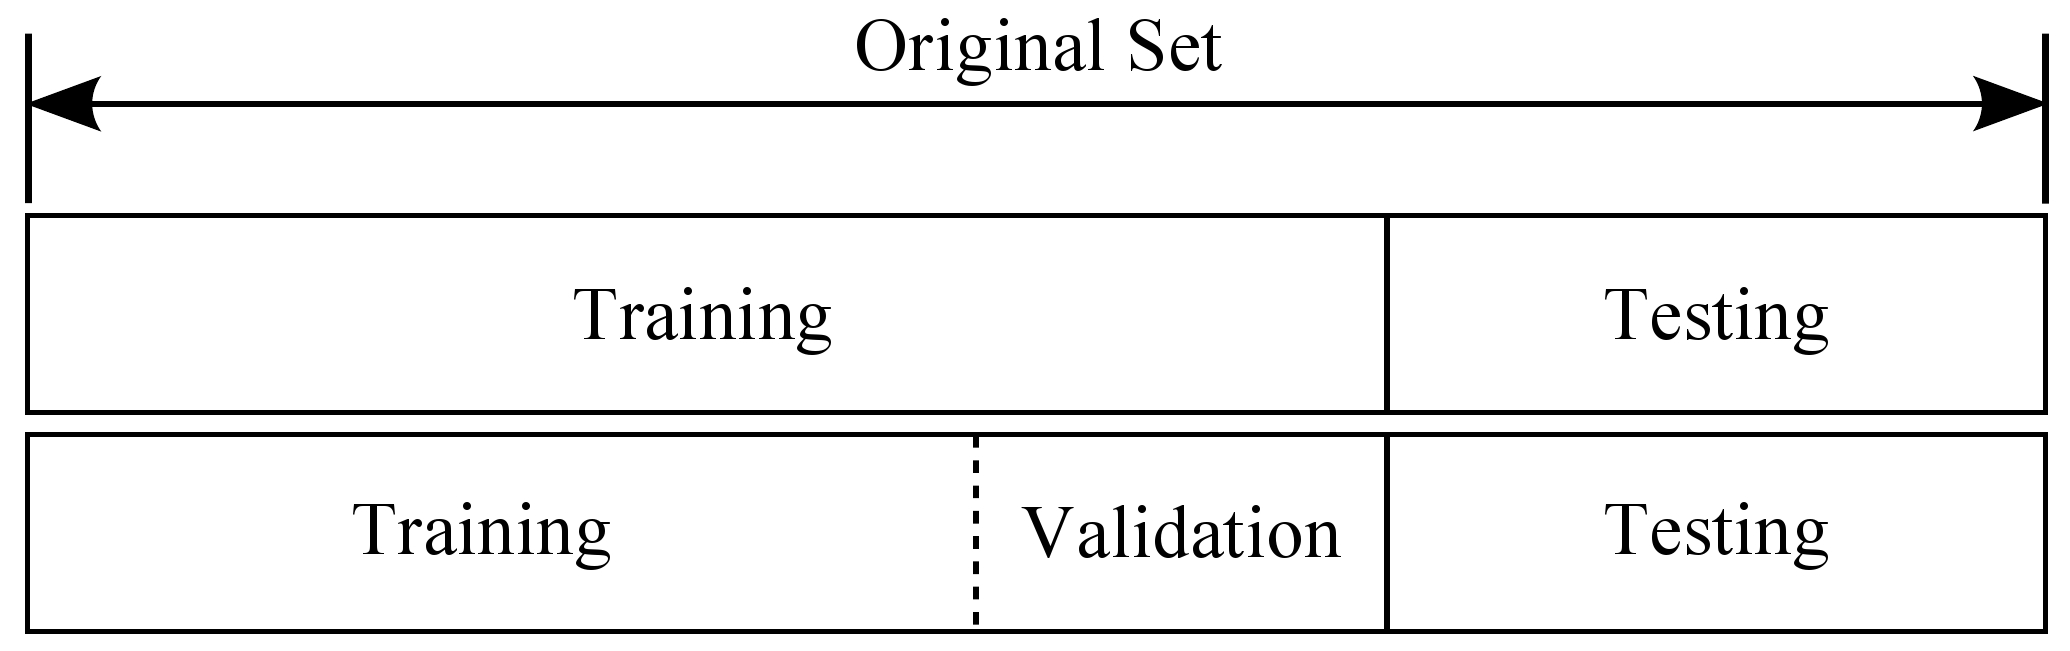

In [0]:
# Split issue date into month and year columns
loan_finished['issue_y']=loan_finished.issue_d.str.split('-',expand=True)[1]
loan_finished['issue_m']=loan_finished.issue_d.str.split('-',expand=True)[0]
loan_finished.issue_y=loan_finished.issue_y.astype(int)

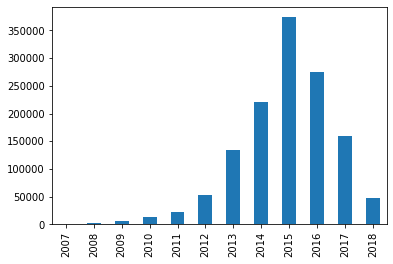

In [60]:
loan_finished.issue_y.value_counts(sort=False).plot(kind='bar',sort_columns=True)

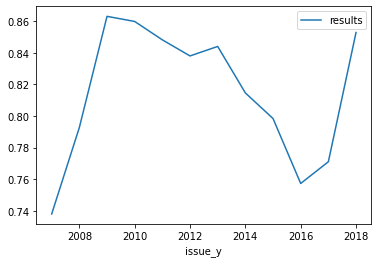

In [58]:
(loan_finished.loc[loan_finished.results=='Fully Paid',['issue_y','results']].groupby(by='issue_y').count()/loan_finished.loc[:,['issue_y','results']].groupby(by='issue_y').count()).plot()

In [63]:
loan_finished.results.value_counts()

Fully Paid     1043940
Charged Off     262416
Name: results, dtype: int64

In [0]:
training = loan_finished.sample(frac =.8, random_state=123)
testing = loan_finished.loc[~loan_finished['id'].isin(training['id'])]

In [67]:
training.results.value_counts()

Fully Paid     834963
Charged Off    210122
Name: results, dtype: int64

In [68]:
testing.results.value_counts()

Fully Paid     208977
Charged Off     52294
Name: results, dtype: int64

In [0]:
# Optional: for saving RAM, to export a csv as training and testing
training.to_csv('/content/drive/My Drive/Colab Notebooks/Lending Club Project_Joint/training.csv',index=False)
testing.to_csv('/content/drive/My Drive/Colab Notebooks/Lending Club Project_Joint/testing.csv',index=False)

## 4. Select Potential Useful & Available Information on Training Data

To select information which are available and useful.

The dataset includes information both before and after the loan application was approved. However, when the model assigns the grade to loans, infomation after the application approval is not available. Those unavailable information will be excluded from the dataset. 

Additionally, the some information is unrelated to the loan but the record, so those information will be excluded too.

In [0]:
training=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Lending Club Project_Joint/training.csv')

In [0]:
back_up=training.copy()

In [0]:
training=training[['id','acc_open_past_24mths','addr_state','annual_inc','annual_inc_joint',
         'application_type','avg_cur_bal','bc_open_to_buy','bc_util','chargeoff_within_12_mths',
         'collections_12_mths_ex_med','delinq_2yrs', 'desc','dti','dti_joint',
         'earliest_cr_line','home_ownership','inq_last_6mths','loan_amnt','num_bc_tl',
         'mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mort_acc', 'mths_since_last_major_derog',
         'mths_since_recent_bc','mths_since_recent_revol_delinq','num_actv_bc_tl', 'num_actv_rev_tl','num_bc_sats',
         'num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats', 
         'num_tl_op_past_12m','open_acc','percent_bc_gt_75','verification_status','verification_status_joint',
         'pub_rec','pub_rec_bankruptcies','purpose','revol_bal','revol_bal_joint',
         'revol_util','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med','sec_app_earliest_cr_line','sec_app_mort_acc',
         'sec_app_mths_since_last_major_derog','sec_app_num_rev_accts','sec_app_open_acc','sec_app_revol_util','term',
         'tot_coll_amt','tot_cur_bal','tot_hi_cred_lim','total_acc','total_bal_ex_mort',
         'total_bal_il','pct_tl_nvr_dlq','results','issue_d']]

In [0]:
# Split issue date into month and year columns
training['issue_y']=training.issue_d.str.split('-',expand=True)[1].astype(int)
training['issue_m']=training.issue_d.str.split('-',expand=True)[0]

In [81]:
training.shape

(1045085, 66)

In [80]:
training.head()

,id,acc_open_past_24mths,addr_state,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,desc,dti,dti_joint,earliest_cr_line,home_ownership,inq_last_6mths,loan_amnt,num_bc_tl,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_last_major_derog,mths_since_recent_bc,mths_since_recent_revol_delinq,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,open_acc,percent_bc_gt_75,verification_status,verification_status_joint,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_revol_util,term,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,pct_tl_nvr_dlq,results,issue_d,issue_y,issue_m
0,1294383,5.0,CA,75000.0,NaN,Individual,8115.0,5315.0,11.4,0.0,0.0,0.0,NaN,20.42,NaN,May-2009,RENT,0.0,12000,1.0,58.0,69.0,22.0,0.0,NaN,69.0,NaN,1.0,1.0,1.0,12.0,2.0,2.0,1.0,6.0,2.0,6.0,0.0,Source Verified,NaN,0.0,0.0,debt_consolidation,685,NaN,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36 months,0.0,48690.0,68842.0,16.0,48690.0,NaN,100.0,Fully Paid,Feb-2015,2015,Feb
1,1876502,0.0,OR,25000.0,NaN,Individual,2054.0,2069.0,73.1,0.0,0.0,0.0,NaN,7.97,NaN,Jul-2006,RENT,0.0,5000,4.0,NaN,100.0,50.0,0.0,NaN,50.0,NaN,2.0,3.0,2.0,0.0,3.0,6.0,3.0,3.0,0.0,3.0,50.0,Not Verified,NaN,0.0,0.0,debt_consolidation,6162,NaN,63.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36 months,0.0,6162.0,9700.0,6.0,6162.0,NaN,100.0,Fully Paid,Nov-2014,2014,Nov
2,954710,0.0,TX,32000.0,NaN,Individual,631.0,526.0,85.8,0.0,0.0,0.0,NaN,11.52,NaN,Sep-2004,RENT,0.0,4000,10.0,135.0,129.0,41.0,0.0,35.0,96.0,58.0,6.0,9.0,6.0,3.0,10.0,15.0,9.0,10.0,0.0,10.0,83.3,Source Verified,NaN,0.0,0.0,credit_card,6312,NaN,69.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36 months,70.0,6312.0,9100.0,18.0,6312.0,NaN,88.9,Fully Paid,Dec-2015,2015,Dec
3,809314,7.0,VA,135000.0,NaN,Individual,29161.0,3000.0,87.0,0.0,0.0,0.0,NaN,23.66,NaN,May-1991,MORTGAGE,0.0,10000,5.0,124.0,296.0,7.0,5.0,35.0,12.0,35.0,1.0,12.0,5.0,11.0,12.0,19.0,10.0,18.0,4.0,18.0,100.0,Source Verified,NaN,0.0,0.0,debt_consolidation,14802,NaN,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36 months,0.0,524910.0,573138.0,35.0,190254.0,175452.0,83.0,Charged Off,Jan-2016,2016,Jan
4,1069627,0.0,IL,35000.0,NaN,Individual,4674.0,7715.0,63.4,0.0,0.0,0.0,NaN,10.22,NaN,Aug-1978,RENT,0.0,14000,7.0,161.0,445.0,61.0,3.0,70.0,61.0,70.0,2.0,2.0,2.0,3.0,2.0,9.0,2.0,3.0,0.0,3.0,50.0,Verified,NaN,0.0,0.0,credit_card,13385,NaN,63.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36 months,0.0,14021.0,22628.0,16.0,14021.0,NaN,87.5,Fully Paid,Oct-2015,2015,Oct


## 5. First and Second Applicants Combanation

The dataset includes two applicants' information. For individual applications, all the second applicants data is unvailable; and for joint applicaitons, all the second applicants data is available.

As most machine learning models can't handle null values, so we will combine the applicant information for joint applicaitons.

Note: Co-borrowers start on 2015, so before that any second borrower related columns having NA before 2015 should carefully handle case by case.

### 5.1 earliest_cr_line & sec_app_earliest_cr_line
**Solution:**
- Select the earleist credit year among all applicants as the combined earliest_cr_line, in new column: **earliest_cr_line_min**

In [0]:
# Extra ealiest credit line year
new=training['earliest_cr_line'].str.split('-', n=1, expand=True)
training['earliest_cr_line1']=new[1]
new=training['sec_app_earliest_cr_line'].str.split('-', n=1, expand=True)
training['sec_app_earliest_cr_line1']=new[1]

# Select ealieast credit line year in joint applications
training.loc[training['application_type'] == 'Individual', 'earliest_cr_line_min'] = training['earliest_cr_line1']
training.loc[training['earliest_cr_line1'] < training['sec_app_earliest_cr_line1'], 'earliest_cr_line_min'] = training['earliest_cr_line1']
training.loc[training['earliest_cr_line1'] >= training['sec_app_earliest_cr_line1'], 'earliest_cr_line_min'] = training['sec_app_earliest_cr_line1']

In [0]:
# Remove processed features
training=training.drop(columns=['earliest_cr_line', 'sec_app_earliest_cr_line'])

### 5.2 verification_status_joint & verification_status

**Solution:**
- Combine verification statuses source_verified and verified as verified
- Mark all applicants verified as verified, otherwise not_verified in new column: **verification_status_all**

In [83]:
# Varification Statuses
training.verification_status.value_counts()

Source Verified    403108
Verified           326582
Not Verified       315395
Name: verification_status, dtype: int64

In [0]:
# Combine Statuses
training['verification_status'].replace({'Source Verified':'Verified'}, inplace=True)
training['verification_status_joint'].replace({'Source Verified':'Verified'}, inplace=True)

# verificantion_status_all for verified individual applicants
training.loc[(training['application_type'] == 'Individual') & (training['verification_status'] == 'Verified'), 'verification_status_all'] = 1

# verificantion_status_all for verified joint applicants
training.loc[(training['application_type'] == 'Joint App') & (training['verification_status'] == 'Verified') & (training['verification_status_joint'] == 'Verified'), 'verification_status_all'] = 1

# Verification_status_all for all not verified applicants
training.loc[training['verification_status_all'] != 1, 'verification_status_all'] = 0

In [0]:
# Remove processed features
training=training.drop(columns=['verification_status_joint','verification_status'])

### 5.3 mths_since_last_major_derog & sec_app_mths_since_last_major_derog
**Solution:**
- If the mths is positive, marked as 1 and if mths is 0 or null, marked as 0 in new column: **if_worse_rating**

In [0]:
# New variable: 'if_worse_rating'
# Original veriable: 'mths_since_last_major_derog', 'sec_app_mths_since_last_major_derog'
# Transformation: Mark either the borrower has worse rate
# Mark 0, if all applicants don't have worse rate, null indicates there is no worse rating
# Mark 1, otherwise

training.loc[(training['application_type'] == 'Individual') & (training['mths_since_last_major_derog'].isna()), 'if_worse_rating'] = 0
training.loc[(training['application_type'] == 'Joint App') & (training['mths_since_last_major_derog'].isna()) & (training['sec_app_mths_since_last_major_derog'].isna()), 'if_worse_rating'] = 0
training.loc[training['if_worse_rating']!=0, 'if_worse_rating'] = 1

In [0]:
# Remove processed features
training=training.drop(columns=['mths_since_last_major_derog','sec_app_mths_since_last_major_derog'])

### 5.4 Aggregate Primary and Secondary Applicants' Information

Since the solution of below variables are the same, those will all be explained in this section.

1. annual_inc & annual_inc_joint
  
  **Solution:** Combine all applicants annual income in new column **annual_inc_all**

2. collections_12_mths_ex_med & sec_app_collections_12_mths_ex_med
  
  **Solution:** Combine two column values in new column **collections_12_mths_ex_med_all**

3. chargeoff_within_12_mths & sec_app_chargeoff_within_12_mths
  
  **Solution:** Combine two column values in new column **chargeoff_within_12_mths_all**

4. revol_bal & revol_bal_joint

  **Solution:** Combine two column values in new column **revol_bal_all**

5. mort_acc & sec_app_mort_acc

  **Solution:** Combine two column values in new cloumn **mort_acc_all**

6. num_rev_accts & sec_app_num_rev_accts

  **Solution:** Combine two column values in new column **num_rev_accts_all**

7. open_acc & sec_app_open_acc

  **Solution:** Combine two column values in new colum **open_acc_all**


In [0]:
# Since applicants with zero income will be marked as null in the table
# In this step, those value will be set as 0
# Step 1: Set null value to 0
null_values={'annual_inc_joint':0,
        'sec_app_collections_12_mths_ex_med':0,
        'sec_app_chargeoff_within_12_mths':0,
        'revol_bal_joint':0,'sec_app_mort_acc':0,
        'sec_app_num_rev_accts':0,'sec_app_open_acc':0}

null_replaced=training.fillna(value=null_values)

# Step 2: Combine all informaiton for all applicants
training['annual_inc_all']                  = training['annual_inc'] + null_replaced['annual_inc_joint']
training['collections_12_mths_ex_med_all']  = training['collections_12_mths_ex_med'] + null_replaced['sec_app_collections_12_mths_ex_med']
training['chargeoff_within_12_mths_all']    = training['chargeoff_within_12_mths'] + null_replaced['sec_app_chargeoff_within_12_mths']
training['revol_bal_all']                   = training['revol_bal'] + null_replaced['revol_bal_joint']
training['mort_acc_all']                    = training['mort_acc'] + null_replaced['sec_app_mort_acc']
training['num_rev_accts_all']               = training['num_rev_accts'] + null_replaced['sec_app_num_rev_accts']
training['open_acc_all']                    = training['open_acc'] + null_replaced['sec_app_open_acc']

In [0]:
# Remove processed features
training=training.drop(columns=['annual_inc', 'annual_inc_joint',
                                'collections_12_mths_ex_med', 'sec_app_collections_12_mths_ex_med',
                                'chargeoff_within_12_mths', 'sec_app_chargeoff_within_12_mths',
                                'revol_bal', 'revol_bal_joint',
                                'mort_acc', 'sec_app_mort_acc',
                                'num_rev_accts', 'sec_app_num_rev_accts',
                                'open_acc', 'sec_app_open_acc'])

In [137]:
training.shape

(1045085, 65)

## 6. Feature Transfermation and Consolidation

During exploration, I realzied that Lending Club's documentation method for some information changed over time. This section will also consolidate those methods.

After the consolidation, for simplication, selected features will also be converted to a binary indication as opposed to the original value.


For example, acc_open_past_24mths includes both 0 and null, and before 2012 Mar. no account opened was marked as null but after was marked as 0.

### 6.1 mths_since_recent_revol_delinq
**Solution:** Set all Null in this column as non recent revoling delinquent, indication as 0, and other non-null value as 1 in new column **if_revol_delinq** (1 yes, 0 no)

Given loans having value of 0 in this column is relatively low, and can be interpretated as recent revoling delinquence less than 1 month.

In [89]:
# Explore Null values in this variable
training.loc[training.mths_since_recent_revol_delinq.isnull(),'issue_y'].value_counts(sort=False)

2007       479
2008      1906
2009      4226
2010     10071
2011     17379
2012     31449
2013     75274
2014    113601
2015    190830
2016    140782
2017     84184
2018     26490
Name: issue_y, dtype: int64

In [90]:
# Explore 0 values in this variable
training.loc[training.mths_since_recent_revol_delinq==0,'issue_y'].value_counts(sort=False)

2012      2
2013     64
2014    136
2015    262
2016    170
2017     94
Name: issue_y, dtype: int64

In [0]:
training.loc[training['mths_since_recent_revol_delinq'].isnull(), 'if_revol_delinq'] = 0
training.loc[training['if_revol_delinq']!=0, 'if_revol_delinq'] = 1

In [0]:
training=training.drop(columns='mths_since_recent_revol_delinq')

### 6.2 total_bal_il

**Solution:** Set Null and 0 as non-installment account adn set other values as having installment account in new column **if_cur_il** (1 yes, 0 no)

As we can see here, NA and 0 appear in different timeframes, which we give us reason to assume they represent the same meaning, that the borrowers don't have installment account. 

In [95]:
# Explore Null values in this variable
training.loc[training.total_bal_il.isnull(),'issue_y'].value_counts(sort=False)

2007       479
2008      1906
2009      4226
2010     10071
2011     17379
2012     42515
2013    107762
2014    177486
2015    283821
2016        38
Name: issue_y, dtype: int64

In [96]:
training.loc[training.total_bal_il==0,'issue_y'].value_counts(sort=False)

2016    22393
2017    13204
2018     4721
2015     1648
Name: issue_y, dtype: int64

In [0]:
training.loc[(training['total_bal_il'].isnull()) | (training['total_bal_il']==0), 'if_cur_il'] = 0
training.loc[training['if_cur_il']!=0, 'if_cur_il'] = 1

In [0]:
training=training.drop(columns='total_bal_il')

### 6.3 delinq_2yrs
**Solution:** Set Null and 0 as no delinquency in recent 2 years and else as delinquented in recent 2 years in new column **if_delinq_2yrs** (1 yes, 0 no)

In [99]:
# Explore Null values in this variable
training.loc[training.delinq_2yrs.isnull(),'issue_y'].value_counts(sort=False)

2007    23
Name: issue_y, dtype: int64

In [100]:
# Explore Null values in this variable
training.loc[training.delinq_2yrs==0,'issue_y'].value_counts(sort=False)

2007       378
2008      1623
2009      3795
2010      8929
2011     15489
2012     36737
2013     89710
2014    140845
2015    237383
2016    174349
2017    102682
2018     32040
Name: issue_y, dtype: int64

In [0]:
training.loc[training['delinq_2yrs']==0, 'if_delinq_2yrs'] = 0
training.loc[training['delinq_2yrs'].isnull(), 'if_delinq_2yrs'] = 0
training.loc[training['if_delinq_2yrs']!=0, 'if_delinq_2yrs'] = 1

In [0]:
training=training.drop(columns='delinq_2yrs')

### 6.4 pub_rec
**Solution:** Set Null and 0 as no derogatory in public record and others as with derogatory in public record in new column **if_pub_rec** (1 yes, 0 no)

In [102]:
# Explore Null values in this variable
training.loc[training.pub_rec.isnull(),'issue_y'].value_counts(sort=False)

2007    23
Name: issue_y, dtype: int64

In [103]:
# Explore 0 values in this variable
training.loc[training.pub_rec==0,'issue_y'].value_counts(sort=False)

2007       427
2008      1755
2009      4022
2010      9475
2011     16461
2012     41326
2013     94926
2014    145667
2015    244485
2016    175224
2017    102118
2018     32041
Name: issue_y, dtype: int64

In [0]:
training.loc[training['pub_rec'].isnull(), 'if_pub_rec'] = 0
training.loc[training['pub_rec']==0, 'if_pub_rec'] = 0
training.loc[training['if_pub_rec']!=0, 'if_pub_rec'] = 1

In [0]:
training=training.drop(columns='pub_rec')

### 6.5 pub_rec_bankruptcies
**Solution:** Set Null and 0 as no bankruptcies in public record and others as with bankruptcies in public record in new column **if_pub_rec_bankruptcies** (1 yes, 0 no)

In [106]:
# Explore Null values in this variable
training.loc[training.pub_rec_bankruptcies.isnull(),'issue_y'].value_counts(sort=False)

2007    464
2008    612
2009      1
Name: issue_y, dtype: int64

In [107]:
# Explore 0 values in this variable
training.loc[training.pub_rec_bankruptcies==0,'issue_y'].value_counts(sort=False)

2007         1
2008      1188
2009      4090
2010      9634
2011     16594
2012     41533
2013     96285
2014    154668
2015    261260
2016    188356
2017    107681
2018     32362
Name: issue_y, dtype: int64

In [0]:
training.loc[training['pub_rec_bankruptcies'].isnull(), 'if_pub_rec_bankruptcies'] = 0
training.loc[training['pub_rec_bankruptcies']==0, 'if_pub_rec_bankruptcies'] = 0
training.loc[training['if_pub_rec_bankruptcies']!=0, 'if_pub_rec_bankruptcies'] = 1

In [0]:
training=training.drop(columns='pub_rec_bankruptcies')

### 6.6 desc
**Solution:** Mark if the applicant provide description about the loan, else in original column **desc**. (1 yes, 0 no)

In [0]:
training.loc[training.desc.isnull(),'desc']=0
training.loc[training.desc!=0,'desc']=1

In [114]:
training.desc.value_counts()

0    944666
1    100419
Name: desc, dtype: int64

### 6.7 chargeoff_within_12_mths_all
**Solution:** Set Null and 0 as no charge off within 12 mths, else with charege off within 12 mths in new column **if_chargeoff_12_mths** (1 yes, 0 no)

In [117]:
# Explore Null values in this variable
training.loc[training.chargeoff_within_12_mths_all.isnull(),'issue_y'].value_counts(sort=False)

2007    114
Name: issue_y, dtype: int64

In [118]:
# Explore 0 values in this variable
training.loc[training.chargeoff_within_12_mths_all == 0,'issue_y'].value_counts(sort=False)

2007       365
2008      1906
2009      4226
2010     10071
2011     17379
2012     42456
2013    107102
2014    175788
2015    296114
2016    217709
2017    125777
2018     37271
Name: issue_y, dtype: int64

In [120]:
training.chargeoff_within_12_mths_all.value_counts(dropna=False)

0.0     1036164
1.0        7922
2.0         657
3.0         124
NaN         114
4.0          45
5.0          22
7.0          10
6.0           8
10.0          7
8.0           5
9.0           4
20.0          1
16.0          1
14.0          1
Name: chargeoff_within_12_mths_all, dtype: int64

In [0]:
training.loc[training['chargeoff_within_12_mths_all'].isnull(), 'if_chargeoff_12_mths'] = 0
training.loc[training['chargeoff_within_12_mths_all']==0, 'if_chargeoff_12_mths'] = 0
training.loc[training['if_chargeoff_12_mths']!=0, 'if_chargeoff_12_mths'] = 1

In [0]:
training=training.drop(columns='chargeoff_within_12_mths_all')

### 6.8 collections_12_mths_ex_med_all

**Solution:** Set Null and 0 as no collection within 12 mths, else with collection within 12 mths in new **column if_collection_12_mths** (1 yes, 0 no)

In [122]:
# Explore Null values in this variable
training.loc[training.collections_12_mths_ex_med_all.isnull(),'issue_y'].value_counts(sort=False)

2007    114
Name: issue_y, dtype: int64

In [123]:
# Explore Null values in this variable
training.loc[training.collections_12_mths_ex_med_all==0,'issue_y'].value_counts(sort=False)

2007       365
2008      1906
2009      4226
2010     10071
2011     17379
2012     42500
2013    107327
2014    174949
2015    293288
2016    215202
2017    123950
2018     36849
Name: issue_y, dtype: int64

In [0]:
training.loc[training['collections_12_mths_ex_med_all'].isnull(), 'if_collections_12_mths'] = 0
training.loc[training['collections_12_mths_ex_med_all']==0, 'if_collections_12_mths'] = 0
training.loc[training['if_collections_12_mths']!=0, 'if_collections_12_mths'] = 1

In [0]:
training=training.drop(columns='collections_12_mths_ex_med_all')

In [145]:
training.shape

(1045085, 58)

### 6.9 Export Transfered Data

In [0]:
training.to_csv('/content/drive/My Drive/Colab Notebooks/Lending Club Project_Joint/training_transformed.csv')